**RNN-Assignment-4**

**Sapna R**
**BS20B032**
___

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [2]:
train_data=datasets.MNIST(root='./',train=True,download=True)
test_data=datasets.MNIST(root='./',train=False,download=True)
X_train=np.zeros((len(train_data),28,28))
y_train=np.zeros((len(train_data),10))

for i in range(len(train_data)):
    X_train[i]=np.array(list(train_data.__getitem__(i))[0])
    y_train[i][list(train_data.__getitem__(i))[1]]=1
X_test=np.zeros((len(test_data),28,28))
y_test=np.zeros((len(test_data),10))
for i in range(len(test_data)):
    X_test[i]=np.array(list(test_data.__getitem__(i))[0])
    y_test[i][list(test_data.__getitem__(i))[1]]=1

In [3]:
class RNN_MNIST(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers=1,bidirectional=False):
        super(RNN_MNIST,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.RNN=nn.RNN(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
        if bidirectional:
            self.fc_layer=nn.Linear(2*hidden_size,output_size)
        else:
            self.fc_layer=nn.Linear(hidden_size,output_size)
        self.softmax=nn.Softmax(dim=1)
        self.bidirectional=bidirectional
    def forward(self,x):
        if self.bidirectional:
            h0=torch.zeros(2*self.num_layers,x.size(0),self.hidden_size).to(x.device)
        else:
            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)

        out,_=self.RNN(x,h0)
        out=out[:,-1,:]
        out=self.fc_layer(out)
        #out=self.softmax(out)
        return out

In [4]:
class LSTM_MNIST(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers=1,bidirectional=False):
        super(LSTM_MNIST,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.LSTM=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
        if bidirectional:
            self.fc_layer=nn.Linear(2*hidden_size,output_size)
        else:
            self.fc_layer=nn.Linear(hidden_size,output_size)
        self.softmax=nn.Softmax(dim=1)
        self.bidirectional=bidirectional
    def forward(self,x):
        if self.bidirectional:
            h0=torch.zeros(2*self.num_layers,x.size(0),self.hidden_size).to(x.device)
            c0=torch.zeros(2*self.num_layers,x.size(0),self.hidden_size).to(x.device)
        else:

            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
            c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
        out,_=self.LSTM(x,(h0,c0))
        out=out[:,-1,:]
        out=self.fc_layer(out)
        #out=self.softmax(out)
        return out

In [5]:
class GRU_MNIST(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers=1,bidirectional=False):
        super(GRU_MNIST,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.GRU=nn.GRU(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
        self.fc_layer=nn.Linear(hidden_size,output_size)
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
        #c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
        out,_=self.LSTM(x,h0)
        out=out[:,-1,:]
        out=self.fc_layer(out)
        #out=self.softmax(out)
        return out

In [6]:
"""model.eval()
with torch.no_grad():
    print(model( torch.tensor(X_train[:64], dtype=torch.float32)).shape)"""

'model.eval()\nwith torch.no_grad():\n    print(model( torch.tensor(X_train[:64], dtype=torch.float32)).shape)'

In [7]:
X_train/=255
X_test/=255

In [8]:
def eval(model,X,y,criterion,batchsize=1000):

  model.eval()
  loss=0.0
  correct_samples=0.0
  dataset=TensorDataset(X,y)
  dataloader=DataLoader(dataset,batch_size=batchsize,shuffle=False)
  for batch_X,batch_y in dataloader:
    with torch.no_grad():
      output=model(batch_X)
      loss+=(criterion(output,batch_y).item())*batch_X.shape[0]
      correct_samples+=torch.sum(torch.argmax(output,dim=1)==torch.argmax(batch_y,dim=1)).item()
  loss/=X.shape[0]
  accuracy=(correct_samples/X.shape[0])*100
  return [loss,accuracy]


In [9]:
def train_model(model, X_train,y_train,X_val,y_val, criterion, optimizer, num_epochs=10, device='cpu'):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    y_val=torch.tensor(y_val,dtype=torch.float32).to(device)
    #print(X_train.device)
    batch_size = 64
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    model=model.to(device)
    train_error=[]
    val_error=[]
    train_accuracy=[]
    val_accuracy=[]
    [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
    [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

    train_accuracy.append(train_acc)
    train_error.append(train_loss)
    val_error.append(val_loss)
    val_accuracy.append(val_acc)
    updates=0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            #print(train_loss)
            # Zero the parameter gradients
            updates+=1
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if updates%200==0:
              [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
              [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

              train_accuracy.append(train_acc)
              train_error.append(train_loss)
              val_error.append(val_loss)
              val_accuracy.append(val_acc)
        """train_output = model(X_train.to(device))
        train_loss = criterion(train_output,y_train)
        train_error.append(train_loss.item())

        val_output=model(X_val)
        val_loss=criterion(val_output,y_val)
        val_error.append(val_loss.item())"""






        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    print('Training complete.')
    return [model,train_error,val_error,train_accuracy,val_accuracy]



In [10]:
#X_train.shape
model_11=RNN_MNIST(28,hidden_size=128,output_size=10,num_layers=1)
batch_size = 64
learning_rate = 0.001
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_11.parameters(), lr=learning_rate)
[model_11,train_error_11,val_error_11,train_accuracy_11,val_accuracy_11]=train_model(model_11,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.8173
Epoch [2/20], Loss: 0.4088
Epoch [3/20], Loss: 0.2902
Epoch [4/20], Loss: 0.2459
Epoch [5/20], Loss: 0.2125
Epoch [6/20], Loss: 0.1894
Epoch [7/20], Loss: 0.1810
Epoch [8/20], Loss: 0.1575
Epoch [9/20], Loss: 0.1521
Epoch [10/20], Loss: 0.1462
Epoch [11/20], Loss: 0.1361
Epoch [12/20], Loss: 0.1281
Epoch [13/20], Loss: 0.1223
Epoch [14/20], Loss: 0.1190
Epoch [15/20], Loss: 0.1158
Epoch [16/20], Loss: 0.1146
Epoch [17/20], Loss: 0.1081
Epoch [18/20], Loss: 0.1034
Epoch [19/20], Loss: 0.1134
Epoch [20/20], Loss: 0.1003
Training complete.


In [11]:
#X_train.shape
model_12=RNN_MNIST(28,hidden_size=256,output_size=10,num_layers=1)
batch_size = 64
learning_rate = 0.001
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_12.parameters(), lr=learning_rate)
[model_12,train_error_12,val_error_12,train_accuracy_12,val_accuracy_12]=train_model(model_12,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.6961
Epoch [2/20], Loss: 0.3348
Epoch [3/20], Loss: 0.2473
Epoch [4/20], Loss: 0.2093
Epoch [5/20], Loss: 0.1768
Epoch [6/20], Loss: 0.1632
Epoch [7/20], Loss: 0.1552
Epoch [8/20], Loss: 0.1560
Epoch [9/20], Loss: 0.1447
Epoch [10/20], Loss: 0.1449
Epoch [11/20], Loss: 0.1224
Epoch [12/20], Loss: 0.1308
Epoch [13/20], Loss: 0.1211
Epoch [14/20], Loss: 0.1181
Epoch [15/20], Loss: 0.1519
Epoch [16/20], Loss: 0.1289
Epoch [17/20], Loss: 0.1221
Epoch [18/20], Loss: 0.1081
Epoch [19/20], Loss: 0.1289
Epoch [20/20], Loss: 0.1147
Training complete.


In [13]:
#X_train.shape
model_13=RNN_MNIST(28,hidden_size=256,output_size=10,num_layers=3)
batch_size = 64
learning_rate = 0.001
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_13.parameters(), lr=learning_rate)
[model_13,train_error_13,val_error_13,train_accuracy_13,val_accuracy_13]=train_model(model_13,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.6314
Epoch [2/20], Loss: 0.3070
Epoch [3/20], Loss: 0.2291
Epoch [4/20], Loss: 0.1940
Epoch [5/20], Loss: 0.1622
Epoch [6/20], Loss: 0.1949
Epoch [7/20], Loss: 0.1739
Epoch [8/20], Loss: 0.1676
Epoch [9/20], Loss: 0.1698
Epoch [10/20], Loss: 0.1871
Epoch [11/20], Loss: 0.2226
Epoch [12/20], Loss: 0.1998
Epoch [13/20], Loss: 0.1706
Epoch [14/20], Loss: 0.1609
Epoch [15/20], Loss: 0.1635
Epoch [16/20], Loss: 0.1604
Epoch [17/20], Loss: 0.1782
Epoch [18/20], Loss: 0.1710
Epoch [19/20], Loss: 0.1770
Epoch [20/20], Loss: 0.2007
Training complete.


In [41]:
model_14=RNN_MNIST(28,hidden_size=256,output_size=10,num_layers=1,bidirectional=True)
batch_size = 64
learning_rate = 0.001
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_14.parameters(), lr=learning_rate)
[model_14,train_error_14,val_error_14,train_accuracy_14,val_accuracy_14]=train_model(model_14,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.7443
Epoch [2/20], Loss: 0.3485
Epoch [3/20], Loss: 0.2558
Epoch [4/20], Loss: 0.2095
Epoch [5/20], Loss: 0.1817
Epoch [6/20], Loss: 0.1726
Epoch [7/20], Loss: 0.1584
Epoch [8/20], Loss: 0.1456
Epoch [9/20], Loss: 0.1417
Epoch [10/20], Loss: 0.1403
Epoch [11/20], Loss: 0.1385
Epoch [12/20], Loss: 0.1292
Epoch [13/20], Loss: 0.1425
Epoch [14/20], Loss: 0.1331
Epoch [15/20], Loss: 0.1255
Epoch [16/20], Loss: 0.1122
Epoch [17/20], Loss: 0.1290
Epoch [18/20], Loss: 0.1369
Epoch [19/20], Loss: 0.1300
Epoch [20/20], Loss: 0.1191
Training complete.


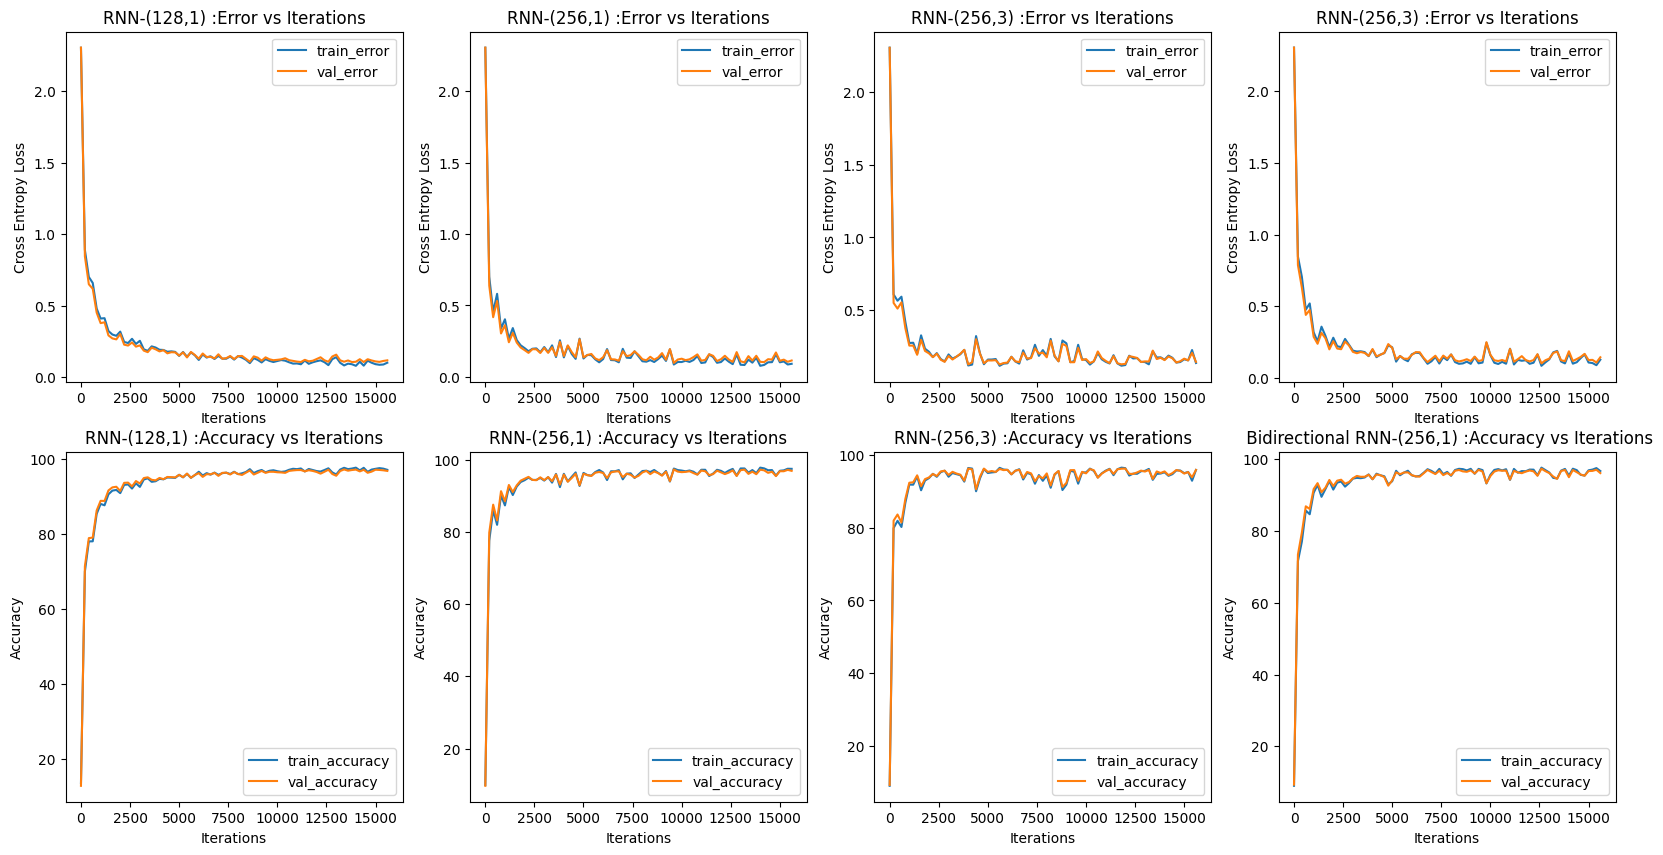

In [42]:
fig,axs=plt.subplots(2,4,figsize=(20,10))
axs[0][0].plot([200*i for i in range(len(train_error_11))],train_error_11,label='train_error')
axs[0][0].plot([200*i for i in range(len(train_error_11))],val_error_11,label='val_error')
axs[0][0].set_xlabel('Iterations')
axs[0][0].set_ylabel('Cross Entropy Loss')
axs[0][0].set_title('RNN-(128,1) :Error vs Iterations')
axs[0][0].legend()

axs[1][0].plot([200*i for i in range(len(train_error_11))],train_accuracy_11,label='train_accuracy')
axs[1][0].plot([200*i for i in range(len(train_error_11))],val_accuracy_11,label='val_accuracy')
axs[1][0].set_xlabel('Iterations')
axs[1][0].set_ylabel('Accuracy')
axs[1][0].set_title('RNN-(128,1) :Accuracy vs Iterations')
axs[1][0].legend()

axs[0][1].plot([200*i for i in range(len(train_error_12))],train_error_12,label='train_error')
axs[0][1].plot([200*i for i in range(len(train_error_12))],val_error_12,label='val_error')
axs[0][1].set_xlabel('Iterations')
axs[0][1].set_ylabel('Cross Entropy Loss')
axs[0][1].set_title('RNN-(256,1) :Error vs Iterations')
axs[0][1].legend()

axs[1][1].plot([200*i for i in range(len(train_error_12))],train_accuracy_12,label='train_accuracy')
axs[1][1].plot([200*i for i in range(len(train_error_12))],val_accuracy_12,label='val_accuracy')
axs[1][1].set_xlabel('Iterations')
axs[1][1].set_ylabel('Accuracy')
axs[1][1].set_title('RNN-(256,1) :Accuracy vs Iterations')
axs[1][1].legend()

axs[0][2].plot([200*i for i in range(len(train_error_13))],train_error_13,label='train_error')
axs[0][2].plot([200*i for i in range(len(train_error_13))],val_error_13,label='val_error')
axs[0][2].set_xlabel('Iterations')
axs[0][2].set_ylabel('Cross Entropy Loss')
axs[0][2].set_title('RNN-(256,3) :Error vs Iterations')
axs[0][2].legend()

axs[1][2].plot([200*i for i in range(len(train_error_13))],train_accuracy_13,label='train_accuracy')
axs[1][2].plot([200*i for i in range(len(train_error_13))],val_accuracy_13,label='val_accuracy')
axs[1][2].set_xlabel('Iterations')
axs[1][2].set_ylabel('Accuracy')
axs[1][2].set_title('RNN-(256,3) :Accuracy vs Iterations')
axs[1][2].legend()

axs[0][3].plot([200*i for i in range(len(train_error_14))],train_error_14,label='train_error')
axs[0][3].plot([200*i for i in range(len(train_error_14))],val_error_14,label='val_error')
axs[0][3].set_xlabel('Iterations')
axs[0][3].set_ylabel('Cross Entropy Loss')
axs[0][3].set_title('RNN-(256,3) :Error vs Iterations')
axs[0][3].legend()

axs[1][3].plot([200*i for i in range(len(train_error_14))],train_accuracy_14,label='train_accuracy')
axs[1][3].plot([200*i for i in range(len(train_error_14))],val_accuracy_14,label='val_accuracy')
axs[1][3].set_xlabel('Iterations')
axs[1][3].set_ylabel('Accuracy')
axs[1][3].set_title(' Bidirectional RNN-(256,1) :Accuracy vs Iterations')
axs[1][3].legend()




plt.show()

In [43]:
device='cpu'
[_,test_accuracy_11]=eval(model_11,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy  of RNN after training RNN with 128 hidden neurons and 1 layer is {test_accuracy_11}')

[_,test_accuracy_12]=eval(model_12,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy of RNN after training with 256 hidden neurons and 1 layer is {test_accuracy_12}')

[_,test_accuracy_13]=eval(model_13,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy of RNN after training with 256 hidden neurons and 3 layers is {test_accuracy_11}')

[_,test_accuracy_14]=eval(model_14,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy of bidirectional RNN after training with 256 hidden neurons and 1 layer is {test_accuracy_11}')

 The average test accuracy  of RNN after training RNN with 128 hidden neurons and 1 layer is 96.74000000000001
 The average test accuracy of RNN after training with 256 hidden neurons and 1 layer is 97.06
 The average test accuracy of RNN after training with 256 hidden neurons and 3 layers is 96.74000000000001
 The average test accuracy of bidirectional RNN after training with 256 hidden neurons and 1 layer is 96.74000000000001


In [24]:
#X_train.shape
model_21=LSTM_MNIST(28,hidden_size=128,output_size=10,num_layers=1)
batch_size = 64
learning_rate = 0.005
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_21.parameters(), lr=learning_rate)
[model_21,train_error_21,val_error_21,train_accuracy_21,val_accuracy_21]=train_model(model_21,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.4327
Epoch [2/20], Loss: 0.1109
Epoch [3/20], Loss: 0.0796
Epoch [4/20], Loss: 0.0662
Epoch [5/20], Loss: 0.0554
Epoch [6/20], Loss: 0.0452
Epoch [7/20], Loss: 0.0402
Epoch [8/20], Loss: 0.0390
Epoch [9/20], Loss: 0.0334
Epoch [10/20], Loss: 0.0309
Epoch [11/20], Loss: 0.0303
Epoch [12/20], Loss: 0.0293
Epoch [13/20], Loss: 0.0279
Epoch [14/20], Loss: 0.0257
Epoch [15/20], Loss: 0.0232
Epoch [16/20], Loss: 0.0185
Epoch [17/20], Loss: 0.0241
Epoch [18/20], Loss: 0.0228
Epoch [19/20], Loss: 0.0254
Epoch [20/20], Loss: 0.0162
Training complete.


In [25]:
device='cpu'
[_,test_accuracy_21]=eval(model_21,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy after training is {test_accuracy_21}')

 The average test accuracy after training is 98.53


In [36]:
#X_train.shape
model_22=LSTM_MNIST(28,hidden_size=128,output_size=10,num_layers=1,bidirectional=True)
batch_size = 64
learning_rate = 0.005
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_22.parameters(), lr=learning_rate)
[model_22,train_error_22,val_error_22,train_accuracy_22,val_accuracy_22]=train_model(model_22,X_train[:50000],y_train[:50000],X_train[50000:],y_train[50000:],criterion,optimizer,num_epochs=20)

Epoch [1/20], Loss: 0.3985
Epoch [2/20], Loss: 0.1094
Epoch [3/20], Loss: 0.0831
Epoch [4/20], Loss: 0.0622
Epoch [5/20], Loss: 0.0525
Epoch [6/20], Loss: 0.0451
Epoch [7/20], Loss: 0.0437
Epoch [8/20], Loss: 0.0396
Epoch [9/20], Loss: 0.0344
Epoch [10/20], Loss: 0.0330
Epoch [11/20], Loss: 0.0286
Epoch [12/20], Loss: 0.0294
Epoch [13/20], Loss: 0.0274
Epoch [14/20], Loss: 0.0237
Epoch [15/20], Loss: 0.0213
Epoch [16/20], Loss: 0.0264
Epoch [17/20], Loss: 0.0207
Epoch [18/20], Loss: 0.0218
Epoch [19/20], Loss: 0.0196
Epoch [20/20], Loss: 0.0194
Training complete.


In [44]:
device='cpu'
[_,test_accuracy_21]=eval(model_21,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy after training LSTM with 128 neurons is {test_accuracy_21}')
device='cpu'
[_,test_accuracy_22]=eval(model_22,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy after training Bidirectional LSTIM with 128 neurons is {test_accuracy_22}')

 The average test accuracy after training LSTM with 128 neurons is 98.53
 The average test accuracy after training Bidirectional LSTIM with 128 neurons is 98.31


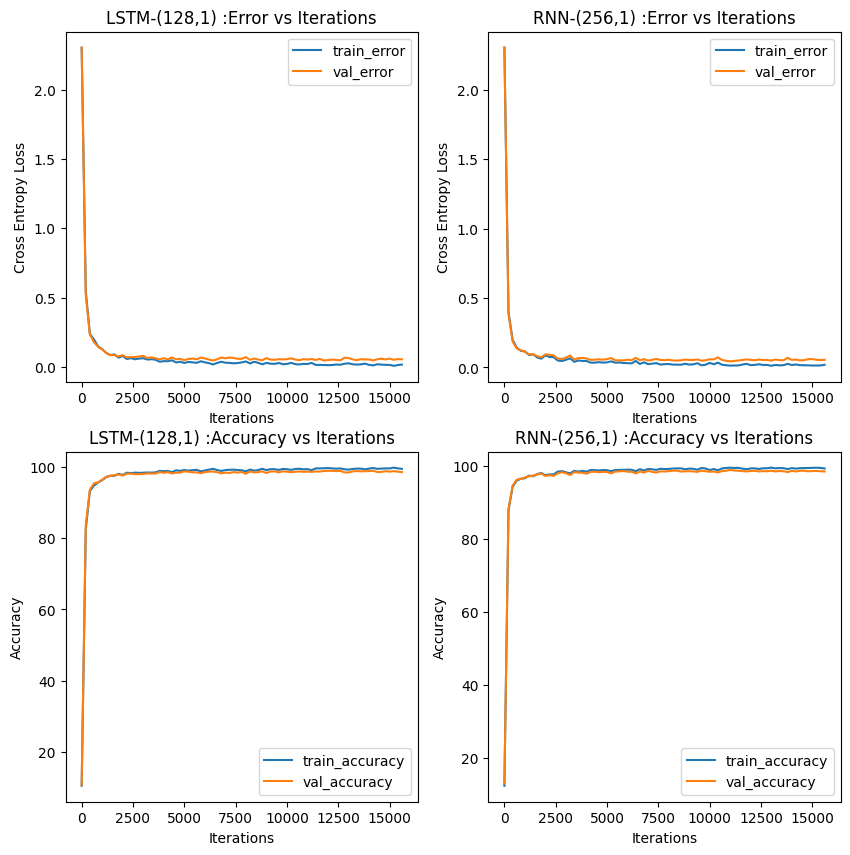

In [45]:
fig,axs=plt.subplots(2,2,figsize=(10,10))

axs[0][0].plot([200*i for i in range(len(train_error_21))],train_error_21,label='train_error')
axs[0][0].plot([200*i for i in range(len(train_error_21))],val_error_21,label='val_error')
axs[0][0].set_xlabel('Iterations')
axs[0][0].set_ylabel('Cross Entropy Loss')
axs[0][0].set_title('LSTM-(128,1) :Error vs Iterations')
axs[0][0].legend()

axs[1][0].plot([200*i for i in range(len(train_error_21))],train_accuracy_21,label='train_accuracy')
axs[1][0].plot([200*i for i in range(len(train_error_21))],val_accuracy_21,label='val_accuracy')
axs[1][0].set_xlabel('Iterations')
axs[1][0].set_ylabel('Accuracy')
axs[1][0].set_title('LSTM-(128,1) :Accuracy vs Iterations')
axs[1][0].legend()

axs[0][1].plot([200*i for i in range(len(train_error_12))],train_error_22,label='train_error')
axs[0][1].plot([200*i for i in range(len(train_error_12))],val_error_22,label='val_error')
axs[0][1].set_xlabel('Iterations')
axs[0][1].set_ylabel('Cross Entropy Loss')
axs[0][1].set_title('RNN-(256,1) :Error vs Iterations')
axs[0][1].legend()

axs[1][1].plot([200*i for i in range(len(train_error_12))],train_accuracy_22,label='train_accuracy')
axs[1][1].plot([200*i for i in range(len(train_error_12))],val_accuracy_22,label='val_accuracy')
axs[1][1].set_xlabel('Iterations')
axs[1][1].set_ylabel('Accuracy')
axs[1][1].set_title('RNN-(256,1) :Accuracy vs Iterations')
axs[1][1].legend()

In [47]:
with torch.no_grad():
      y_pred_test_21=model_21(torch.tensor(X_test,dtype=torch.float32).to(device)).numpy()

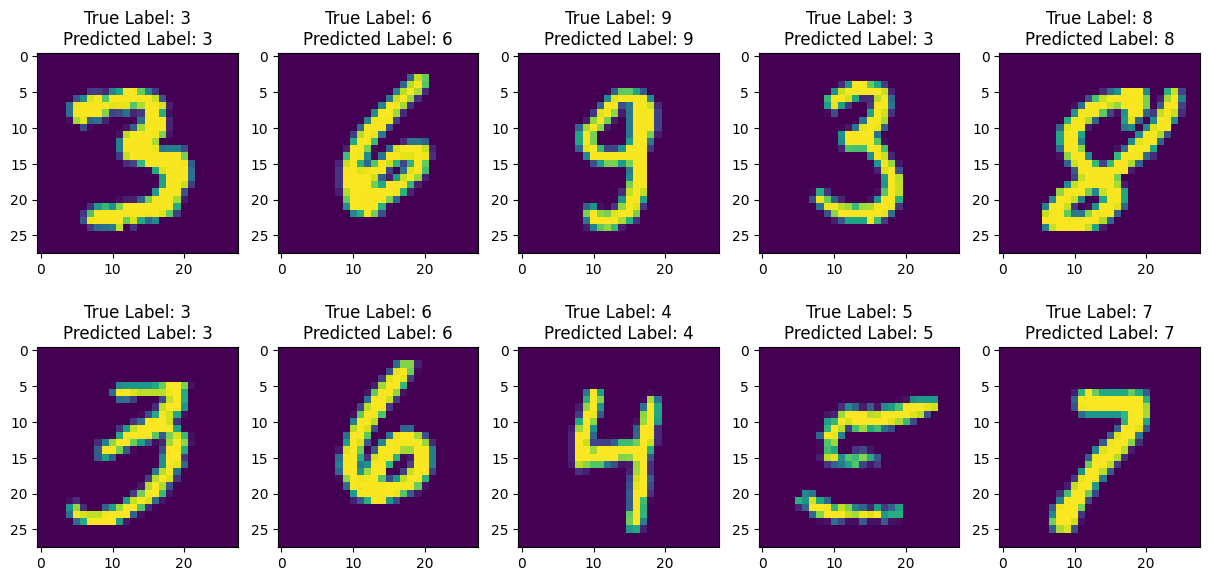

In [49]:
indices=np.random.randint(0,X_test.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(15,7))
k=0
for i in range(2):
  for j in range(5):
    true_label=np.argmax(y_test[indices[k]])
    predicted_label=np.argmax(y_pred_test_21[indices[k]])
    axs[i,j].imshow(X_test[indices[k]])
    axs[i,j].set_title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    k+=1


plt.show()

In [79]:
import os
from PIL import Image
def load_images_from_path(path):
    images_list=[]
    for file in os.listdir(path):
        if file.endswith('.png'):
            file_path=os.path.join(path,file)
            with Image.open(file_path) as img:
                images_list.append(np.array(img.convert('L'))/255)
    return np.array(images_list)
custom_input=load_images_from_path(os.getcwd())


In [80]:
with torch.no_grad():
      y_custom_input_21=model_21(torch.tensor(custom_input,dtype=torch.float32).to(device)).numpy()

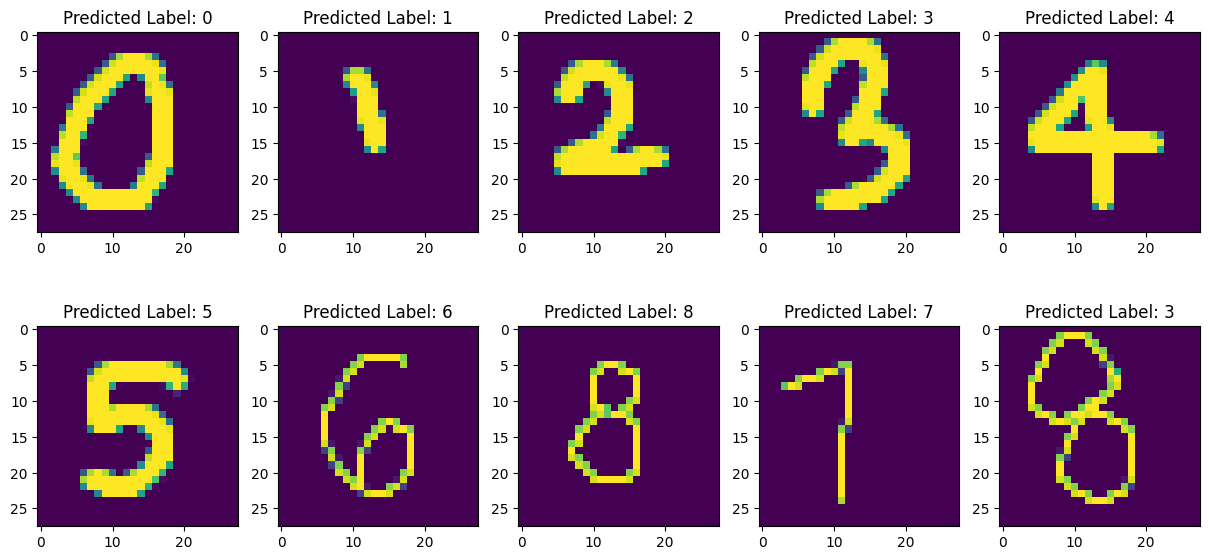

In [81]:
fig,axs=plt.subplots(2,5,figsize=(15,7))
k=0
for i in range(2):
  for j in range(5):
    #true_label=np.argmax(y_custom_input_21[k])
    predicted_label=np.argmax(y_custom_input_21[k])
    axs[i,j].imshow(custom_input[k])
    axs[i,j].set_title(f'Predicted Label: {predicted_label}')
    k+=1


plt.show()

Part 2

In [14]:
def binary(n,L):
    arr=[0 for i in range(L+1)]
    k=0
    while n!=0:
        arr[k]=n%2
        n//=2
        k+=1
    return arr
print(binary(6,3))

[0, 1, 1, 0]


In [29]:
def generate_random_data(L):
    X=[]
    Y=[]
    for i in range(100):
        x1=np.random.randint(0,2**L)
        x2=np.random.randint(0,2**L)
        curr_X1=binary(x1,L)
        curr_X2=binary(x2,L)
        X.append(np.array([curr_X1]+[curr_X2]).T)
        curr_Y=binary(x1+x2,L)
        Y.append(curr_Y)
    X=np.array(X)
    #X=np.expand_dims(X,axis=-1)
    Y=np.array(Y)
    #Y=np.expand_dims(Y,axis=1)
    Y=np.expand_dims(Y,axis=-1)
    return [X,Y]
generate_random_data(3)[0].shape

(100, 4, 2)

In [28]:
def generate_data(L):
    #generated_nos=[]
    X=[]
    Y=[]
    for i in range(2**L):
        for j in range(2**L):
            curr_X1=binary(i,L)
            curr_X2=binary(j,L)
            X.append(np.array([curr_X1]+[curr_X2]).T)
            curr_Y=binary(i+j,L)
            Y.append(curr_Y)
    X=np.array(X)
    #X=np.expand_dims(X,axis=-1)
    Y=np.array(Y)
    #Y=np.expand_dims(Y,axis=1)
    Y=np.expand_dims(Y,axis=-1)
    return [X,Y]
generate_data(3)[1].shape

    

(64, 4, 1)

In [128]:
def eval(model,X,y,criterion,batchsize=1000):

  model.eval()
  loss=0.0
  correct_samples=0.0
  dataset=TensorDataset(X,y)
  dataloader=DataLoader(dataset,batch_size=batchsize,shuffle=False)
  correct_samples=0
  for batch_X,batch_y in dataloader:
    with torch.no_grad():
      output=model(batch_X)
      loss+=(criterion(output,batch_y).item())*batch_X.shape[0]
      predicted=(output>=0.5).int()
      correct=(predicted==batch_y).int()
      
      #f=1
      for i in range(batch_X.size(0)):
        if torch.sum(predicted[i]-batch_y[i]).item()==0:
          correct_samples+=1
  loss/=X.shape[0]
  accuracy=(correct_samples/X.shape[0])*100
  return [loss,accuracy]


In [131]:
[_,a]=eval(model5_1,torch.tensor(X3,dtype=torch.float32),torch.tensor(Y3,dtype=torch.float32),criterion,batchsize=1000)

In [132]:
a

100.0

In [61]:
a=torch.tensor([0.4,0.5])
(a>=0.5).int()

tensor([0, 1], dtype=torch.int32)

In [147]:
[X1,Y1]=generate_data(3)
[X2,Y2]=generate_data(5)
[X3,Y3]=generate_data(10)

In [63]:
class LSTM_bit(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers=1,bidirectional=False):
        super(LSTM_bit,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.LSTM=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
        if bidirectional:
            self.fc_layer=nn.Linear(2*hidden_size,output_size)
        else:
            self.fc_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()
        self.bidirectional=bidirectional
    def forward(self,x):
        if self.bidirectional:
            h0=torch.zeros(2*self.num_layers,x.size(0),self.hidden_size).to(x.device)
            c0=torch.zeros(2*self.num_layers,x.size(0),self.hidden_size).to(x.device)
        else:

            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
            c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
        out,_=self.LSTM(x,(h0,c0))
        #out=out[:,-1,:]
        out=self.fc_layer(out)
        out=self.sigmoid(out)
        return out

In [65]:
def train_model(model, X_train,y_train,X_val,y_val, criterion, optimizer, num_epochs=10, device='cpu'):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    y_val=torch.tensor(y_val,dtype=torch.float32).to(device)
    #print(X_train.device)
    batch_size = 4
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    model=model.to(device)
    train_error=[]
    val_error=[]
    train_accuracy=[]
    val_accuracy=[]
    [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
    [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

    train_accuracy.append(train_acc)
    train_error.append(train_loss)
    val_error.append(val_loss)
    val_accuracy.append(val_acc)
    updates=0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            #print(train_loss)
            # Zero the parameter gradients
            updates+=1
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if updates%200==0:
              [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
              [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

              train_accuracy.append(train_acc)
              train_error.append(train_loss)
              val_error.append(val_loss)
              val_accuracy.append(val_acc)
        


        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    print('Training complete.')
    return [model,train_error,val_error,train_accuracy,val_accuracy]



In [89]:
model3_1=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model3_2=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model3_3=LSTM_bit(input_size=2,output_size=1,hidden_size=7)
model3_4=LSTM_bit(input_size=2,output_size=1,hidden_size=9)

In [ ]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model3_1.parameters(), lr=learning_rate)
[model3_1,train_error3_1,val_error3_1,train_accuracy3_1,val_accuracy3_1]=train_model(model3_1,X1[:48],Y1[:48],X1[48:],Y1[48:],criterion,optimizer,num_epochs=50)

Epoch [1/150], Loss: 0.2545
Epoch [2/150], Loss: 0.2541
Epoch [3/150], Loss: 0.2536
Epoch [4/150], Loss: 0.2532
Epoch [5/150], Loss: 0.2528
Epoch [6/150], Loss: 0.2525
Epoch [7/150], Loss: 0.2521
Epoch [8/150], Loss: 0.2518
Epoch [9/150], Loss: 0.2514
Epoch [10/150], Loss: 0.2512
Epoch [11/150], Loss: 0.2508
Epoch [12/150], Loss: 0.2506
Epoch [13/150], Loss: 0.2504
Epoch [14/150], Loss: 0.2500
Epoch [15/150], Loss: 0.2498
Epoch [16/150], Loss: 0.2496
Epoch [17/150], Loss: 0.2493
Epoch [18/150], Loss: 0.2491
Epoch [19/150], Loss: 0.2489
Epoch [20/150], Loss: 0.2487
Epoch [21/150], Loss: 0.2485
Epoch [22/150], Loss: 0.2484
Epoch [23/150], Loss: 0.2482
Epoch [24/150], Loss: 0.2480
Epoch [25/150], Loss: 0.2478
Epoch [26/150], Loss: 0.2477
Epoch [27/150], Loss: 0.2475
Epoch [28/150], Loss: 0.2473
Epoch [29/150], Loss: 0.2472
Epoch [30/150], Loss: 0.2470
Epoch [31/150], Loss: 0.2469
Epoch [32/150], Loss: 0.2468
Epoch [33/150], Loss: 0.2466
Epoch [34/150], Loss: 0.2465
Epoch [35/150], Loss: 0

In [ ]:
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.BCELoss()
optimizer = optim.Adam(model3_2.parameters(), lr=learning_rate)
[model3_2,train_error3_2,val_error3_2,train_accuracy3_2,val_accuracy3_2]=train_model(model3_2,X1[:48],Y1[:48],X1[48:],Y1[48:],criterion,optimizer,num_epochs=50)

Epoch [1/150], Loss: 0.6977
Epoch [2/150], Loss: 0.6967
Epoch [3/150], Loss: 0.6959
Epoch [4/150], Loss: 0.6951
Epoch [5/150], Loss: 0.6943
Epoch [6/150], Loss: 0.6937
Epoch [7/150], Loss: 0.6929
Epoch [8/150], Loss: 0.6923
Epoch [9/150], Loss: 0.6916
Epoch [10/150], Loss: 0.6909
Epoch [11/150], Loss: 0.6903
Epoch [12/150], Loss: 0.6897
Epoch [13/150], Loss: 0.6892
Epoch [14/150], Loss: 0.6885
Epoch [15/150], Loss: 0.6881
Epoch [16/150], Loss: 0.6876
Epoch [17/150], Loss: 0.6870
Epoch [18/150], Loss: 0.6865
Epoch [19/150], Loss: 0.6860
Epoch [20/150], Loss: 0.6855
Epoch [21/150], Loss: 0.6851
Epoch [22/150], Loss: 0.6846
Epoch [23/150], Loss: 0.6841
Epoch [24/150], Loss: 0.6836
Epoch [25/150], Loss: 0.6832
Epoch [26/150], Loss: 0.6827
Epoch [27/150], Loss: 0.6822
Epoch [28/150], Loss: 0.6818
Epoch [29/150], Loss: 0.6813
Epoch [30/150], Loss: 0.6808
Epoch [31/150], Loss: 0.6804
Epoch [32/150], Loss: 0.6798
Epoch [33/150], Loss: 0.6794
Epoch [34/150], Loss: 0.6789
Epoch [35/150], Loss: 0

In [ ]:
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.BCELoss()
optimizer = optim.Adam(model3_3.parameters(), lr=learning_rate)
[model3_3,train_error3_3,val_error3_3,train_accuracy3_3,val_accuracy3_3]=train_model(model3_3,X1[:48],Y1[:48],X1[48:],Y1[48:],criterion,optimizer,num_epochs=50)

Epoch [1/150], Loss: 0.6930
Epoch [2/150], Loss: 0.6926
Epoch [3/150], Loss: 0.6921
Epoch [4/150], Loss: 0.6917
Epoch [5/150], Loss: 0.6913
Epoch [6/150], Loss: 0.6909
Epoch [7/150], Loss: 0.6905
Epoch [8/150], Loss: 0.6902
Epoch [9/150], Loss: 0.6898
Epoch [10/150], Loss: 0.6895
Epoch [11/150], Loss: 0.6891
Epoch [12/150], Loss: 0.6888
Epoch [13/150], Loss: 0.6884
Epoch [14/150], Loss: 0.6881
Epoch [15/150], Loss: 0.6877
Epoch [16/150], Loss: 0.6874
Epoch [17/150], Loss: 0.6871
Epoch [18/150], Loss: 0.6868
Epoch [19/150], Loss: 0.6864
Epoch [20/150], Loss: 0.6861
Epoch [21/150], Loss: 0.6857
Epoch [22/150], Loss: 0.6853
Epoch [23/150], Loss: 0.6850
Epoch [24/150], Loss: 0.6846
Epoch [25/150], Loss: 0.6842
Epoch [26/150], Loss: 0.6839
Epoch [27/150], Loss: 0.6834
Epoch [28/150], Loss: 0.6830
Epoch [29/150], Loss: 0.6826
Epoch [30/150], Loss: 0.6822
Epoch [31/150], Loss: 0.6817
Epoch [32/150], Loss: 0.6813
Epoch [33/150], Loss: 0.6807
Epoch [34/150], Loss: 0.6804
Epoch [35/150], Loss: 0

In [ ]:
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.BCELoss()
optimizer = optim.Adam(model3_4.parameters(), lr=learning_rate)
[model3_4,train_error3_4,val_error3_4,train_accuracy3_4,val_accuracy3_4]=train_model(model3_4,X1[:48],Y1[:48],X1[48:],Y1[48:],criterion,optimizer,num_epochs=50)

Epoch [1/150], Loss: 0.6907
Epoch [2/150], Loss: 0.6903
Epoch [3/150], Loss: 0.6898
Epoch [4/150], Loss: 0.6895
Epoch [5/150], Loss: 0.6892
Epoch [6/150], Loss: 0.6888
Epoch [7/150], Loss: 0.6885
Epoch [8/150], Loss: 0.6882
Epoch [9/150], Loss: 0.6879
Epoch [10/150], Loss: 0.6875
Epoch [11/150], Loss: 0.6872
Epoch [12/150], Loss: 0.6869
Epoch [13/150], Loss: 0.6866
Epoch [14/150], Loss: 0.6863
Epoch [15/150], Loss: 0.6859
Epoch [16/150], Loss: 0.6857
Epoch [17/150], Loss: 0.6852
Epoch [18/150], Loss: 0.6849
Epoch [19/150], Loss: 0.6845
Epoch [20/150], Loss: 0.6841
Epoch [21/150], Loss: 0.6837
Epoch [22/150], Loss: 0.6832
Epoch [23/150], Loss: 0.6828
Epoch [24/150], Loss: 0.6823
Epoch [25/150], Loss: 0.6817
Epoch [26/150], Loss: 0.6812
Epoch [27/150], Loss: 0.6807
Epoch [28/150], Loss: 0.6799
Epoch [29/150], Loss: 0.6794
Epoch [30/150], Loss: 0.6787
Epoch [31/150], Loss: 0.6779
Epoch [32/150], Loss: 0.6772
Epoch [33/150], Loss: 0.6764
Epoch [34/150], Loss: 0.6756
Epoch [35/150], Loss: 0

In [135]:
model4_1=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model4_2=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model4_3=LSTM_bit(input_size=2,output_size=1,hidden_size=7)
model4_4=LSTM_bit(input_size=2,output_size=1,hidden_size=9)

In [136]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model4_1.parameters(), lr=learning_rate)
[model4_1,train_error4_1,val_error4_1,train_accuracy4_1,val_accuracy4_1]=train_model(model4_1,X2[:768],Y2[:768],X2[768:],Y2[768:],criterion,optimizer,num_epochs=50)

Epoch [1/50], Loss: 0.2543
Epoch [2/50], Loss: 0.2487
Epoch [3/50], Loss: 0.2474
Epoch [4/50], Loss: 0.2464
Epoch [5/50], Loss: 0.2451
Epoch [6/50], Loss: 0.2436
Epoch [7/50], Loss: 0.2419
Epoch [8/50], Loss: 0.2402
Epoch [9/50], Loss: 0.2384
Epoch [10/50], Loss: 0.2362
Epoch [11/50], Loss: 0.2338
Epoch [12/50], Loss: 0.2311
Epoch [13/50], Loss: 0.2283
Epoch [14/50], Loss: 0.2253
Epoch [15/50], Loss: 0.2221
Epoch [16/50], Loss: 0.2187
Epoch [17/50], Loss: 0.2151
Epoch [18/50], Loss: 0.2111
Epoch [19/50], Loss: 0.2069
Epoch [20/50], Loss: 0.2025
Epoch [21/50], Loss: 0.1978
Epoch [22/50], Loss: 0.1930
Epoch [23/50], Loss: 0.1880
Epoch [24/50], Loss: 0.1829
Epoch [25/50], Loss: 0.1776
Epoch [26/50], Loss: 0.1722
Epoch [27/50], Loss: 0.1667
Epoch [28/50], Loss: 0.1609
Epoch [29/50], Loss: 0.1550
Epoch [30/50], Loss: 0.1490
Epoch [31/50], Loss: 0.1428
Epoch [32/50], Loss: 0.1367
Epoch [33/50], Loss: 0.1305
Epoch [34/50], Loss: 0.1244
Epoch [35/50], Loss: 0.1185
Epoch [36/50], Loss: 0.1130
E

In [137]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model4_2.parameters(), lr=learning_rate)
[model4_2,train_error4_2,val_error4_2,train_accuracy4_2,val_accuracy4_2]=train_model(model4_2,X2[:768],Y2[:768],X2[768:],Y2[768:],criterion,optimizer,num_epochs=50)

Epoch [1/50], Loss: 0.2571
Epoch [2/50], Loss: 0.2502
Epoch [3/50], Loss: 0.2493
Epoch [4/50], Loss: 0.2488
Epoch [5/50], Loss: 0.2483
Epoch [6/50], Loss: 0.2476
Epoch [7/50], Loss: 0.2469
Epoch [8/50], Loss: 0.2461
Epoch [9/50], Loss: 0.2451
Epoch [10/50], Loss: 0.2443
Epoch [11/50], Loss: 0.2434
Epoch [12/50], Loss: 0.2427
Epoch [13/50], Loss: 0.2418
Epoch [14/50], Loss: 0.2408
Epoch [15/50], Loss: 0.2398
Epoch [16/50], Loss: 0.2386
Epoch [17/50], Loss: 0.2372
Epoch [18/50], Loss: 0.2357
Epoch [19/50], Loss: 0.2339
Epoch [20/50], Loss: 0.2319
Epoch [21/50], Loss: 0.2296
Epoch [22/50], Loss: 0.2268
Epoch [23/50], Loss: 0.2237
Epoch [24/50], Loss: 0.2202
Epoch [25/50], Loss: 0.2162
Epoch [26/50], Loss: 0.2118
Epoch [27/50], Loss: 0.2069
Epoch [28/50], Loss: 0.2016
Epoch [29/50], Loss: 0.1960
Epoch [30/50], Loss: 0.1900
Epoch [31/50], Loss: 0.1838
Epoch [32/50], Loss: 0.1773
Epoch [33/50], Loss: 0.1707
Epoch [34/50], Loss: 0.1641
Epoch [35/50], Loss: 0.1574
Epoch [36/50], Loss: 0.1507
E

In [138]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model4_3.parameters(), lr=learning_rate)
[model4_3,train_error4_3,val_error4_3,train_accuracy4_3,val_accuracy4_3]=train_model(model4_3,X2[:768],Y2[:768],X2[768:],Y2[768:],criterion,optimizer,num_epochs=50)

Epoch [1/50], Loss: 0.2494
Epoch [2/50], Loss: 0.2483
Epoch [3/50], Loss: 0.2470
Epoch [4/50], Loss: 0.2449
Epoch [5/50], Loss: 0.2423
Epoch [6/50], Loss: 0.2398
Epoch [7/50], Loss: 0.2368
Epoch [8/50], Loss: 0.2337
Epoch [9/50], Loss: 0.2303
Epoch [10/50], Loss: 0.2268
Epoch [11/50], Loss: 0.2233
Epoch [12/50], Loss: 0.2197
Epoch [13/50], Loss: 0.2159
Epoch [14/50], Loss: 0.2120
Epoch [15/50], Loss: 0.2078
Epoch [16/50], Loss: 0.2034
Epoch [17/50], Loss: 0.1984
Epoch [18/50], Loss: 0.1927
Epoch [19/50], Loss: 0.1863
Epoch [20/50], Loss: 0.1795
Epoch [21/50], Loss: 0.1722
Epoch [22/50], Loss: 0.1649
Epoch [23/50], Loss: 0.1578
Epoch [24/50], Loss: 0.1507
Epoch [25/50], Loss: 0.1435
Epoch [26/50], Loss: 0.1363
Epoch [27/50], Loss: 0.1293
Epoch [28/50], Loss: 0.1222
Epoch [29/50], Loss: 0.1153
Epoch [30/50], Loss: 0.1089
Epoch [31/50], Loss: 0.1024
Epoch [32/50], Loss: 0.0965
Epoch [33/50], Loss: 0.0910
Epoch [34/50], Loss: 0.0859
Epoch [35/50], Loss: 0.0812
Epoch [36/50], Loss: 0.0770
E

In [139]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model4_4.parameters(), lr=learning_rate)
[model4_4,train_error4_4,val_error4_4,train_accuracy4_4,val_accuracy4_4]=train_model(model4_4,X2[:768],Y2[:768],X2[768:],Y2[768:],criterion,optimizer,num_epochs=50)

Epoch [1/50], Loss: 0.2494
Epoch [2/50], Loss: 0.2483
Epoch [3/50], Loss: 0.2474
Epoch [4/50], Loss: 0.2462
Epoch [5/50], Loss: 0.2446
Epoch [6/50], Loss: 0.2427
Epoch [7/50], Loss: 0.2407
Epoch [8/50], Loss: 0.2385
Epoch [9/50], Loss: 0.2363
Epoch [10/50], Loss: 0.2341
Epoch [11/50], Loss: 0.2316
Epoch [12/50], Loss: 0.2290
Epoch [13/50], Loss: 0.2263
Epoch [14/50], Loss: 0.2235
Epoch [15/50], Loss: 0.2204
Epoch [16/50], Loss: 0.2171
Epoch [17/50], Loss: 0.2137
Epoch [18/50], Loss: 0.2101
Epoch [19/50], Loss: 0.2064
Epoch [20/50], Loss: 0.2024
Epoch [21/50], Loss: 0.1982
Epoch [22/50], Loss: 0.1938
Epoch [23/50], Loss: 0.1890
Epoch [24/50], Loss: 0.1841
Epoch [25/50], Loss: 0.1786
Epoch [26/50], Loss: 0.1725
Epoch [27/50], Loss: 0.1657
Epoch [28/50], Loss: 0.1584
Epoch [29/50], Loss: 0.1506
Epoch [30/50], Loss: 0.1427
Epoch [31/50], Loss: 0.1349
Epoch [32/50], Loss: 0.1274
Epoch [33/50], Loss: 0.1199
Epoch [34/50], Loss: 0.1130
Epoch [35/50], Loss: 0.1062
Epoch [36/50], Loss: 0.1001
E

In [140]:
model5_1=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model5_2=LSTM_bit(input_size=2,output_size=1,hidden_size=5)
model5_3=LSTM_bit(input_size=2,output_size=1,hidden_size=7)
model5_4=LSTM_bit(input_size=2,output_size=1,hidden_size=9)

In [148]:
X3.shape

(1048576, 11, 2)

In [141]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model5_1.parameters(), lr=learning_rate)
[model5_1,train_error5_1,val_error5_1,train_accurac5_1,val_accuracy5_1]=train_model(model5_1,X3[:12288],Y3[:12288],X3[12288:],Y3[12288:],criterion,optimizer,num_epochs=150)

Epoch [1/150], Loss: 0.2457
Epoch [2/150], Loss: 0.2000
Epoch [3/150], Loss: 0.1257
Epoch [4/150], Loss: 0.0741
Epoch [5/150], Loss: 0.0356
Epoch [6/150], Loss: 0.0124
Epoch [7/150], Loss: 0.0036
Epoch [8/150], Loss: 0.0010
Epoch [9/150], Loss: 0.0003
Epoch [10/150], Loss: 0.0001
Epoch [11/150], Loss: 0.0000
Epoch [12/150], Loss: 0.0000
Epoch [13/150], Loss: 0.0000
Epoch [14/150], Loss: 0.0000
Epoch [15/150], Loss: 0.0000
Epoch [16/150], Loss: 0.0000
Epoch [17/150], Loss: 0.0000
Epoch [18/150], Loss: 0.0000
Epoch [19/150], Loss: 0.0000
Epoch [20/150], Loss: 0.0000
Epoch [21/150], Loss: 0.0000
Epoch [22/150], Loss: 0.0000
Epoch [23/150], Loss: 0.0000
Epoch [24/150], Loss: 0.0000
Epoch [25/150], Loss: 0.0000
Epoch [26/150], Loss: 0.0000
Epoch [27/150], Loss: 0.0000
Epoch [28/150], Loss: 0.0000
Epoch [29/150], Loss: 0.0000
Epoch [30/150], Loss: 0.0000
Epoch [31/150], Loss: 0.0000
Epoch [32/150], Loss: 0.0000
Epoch [33/150], Loss: 0.0000
Epoch [34/150], Loss: 0.0000
Epoch [35/150], Loss: 0

In [142]:
#model_14=LSTM_bit(2,hidden_size=256,output_size=10,num_layers=1,bidirectional=False)
batch_size = 64
learning_rate = 0.0005
num_epochs = 15
criterion = nn.MSELoss()
optimizer = optim.Adam(model5_2.parameters(), lr=learning_rate)
[model5_2,train_error5_2,val_error5_2,train_accurac5_2,val_accuracy5_2]=train_model(model5_2,X3[:12288],Y3[:12288],X3[12288:],Y3[12288:],criterion,optimizer,num_epochs=150)

Epoch [1/150], Loss: 0.2436
Epoch [2/150], Loss: 0.2093
Epoch [3/150], Loss: 0.1505
Epoch [4/150], Loss: 0.0830
Epoch [5/150], Loss: 0.0659
Epoch [6/150], Loss: 0.0628
Epoch [7/150], Loss: 0.0577
Epoch [8/150], Loss: 0.0533
Epoch [9/150], Loss: 0.0457
Epoch [10/150], Loss: 0.0299
Epoch [11/150], Loss: 0.0156
Epoch [12/150], Loss: 0.0076
Epoch [13/150], Loss: 0.0036
Epoch [14/150], Loss: 0.0017
Epoch [15/150], Loss: 0.0008
Epoch [16/150], Loss: 0.0004
Epoch [17/150], Loss: 0.0002
Epoch [18/150], Loss: 0.0001
Epoch [19/150], Loss: 0.0001
Epoch [20/150], Loss: 0.0000
Epoch [21/150], Loss: 0.0000
Epoch [22/150], Loss: 0.0000
Epoch [23/150], Loss: 0.0000
Epoch [24/150], Loss: 0.0000
Epoch [25/150], Loss: 0.0000
Epoch [26/150], Loss: 0.0000
Epoch [27/150], Loss: 0.0000
Epoch [28/150], Loss: 0.0000
Epoch [29/150], Loss: 0.0000
Epoch [30/150], Loss: 0.0000
Epoch [31/150], Loss: 0.0000
Epoch [32/150], Loss: 0.0000
Epoch [33/150], Loss: 0.0000
Epoch [34/150], Loss: 0.0000
Epoch [35/150], Loss: 0

In [143]:
#[model5_2,train_error5_2,val_error5_2,train_accurac5_2,val_accuracy5_2]=train_model(model5_2,X3[:12288],Y3[:12288],X3[12288:],Y3[12288:],criterion,optimizer,num_epochs=70)

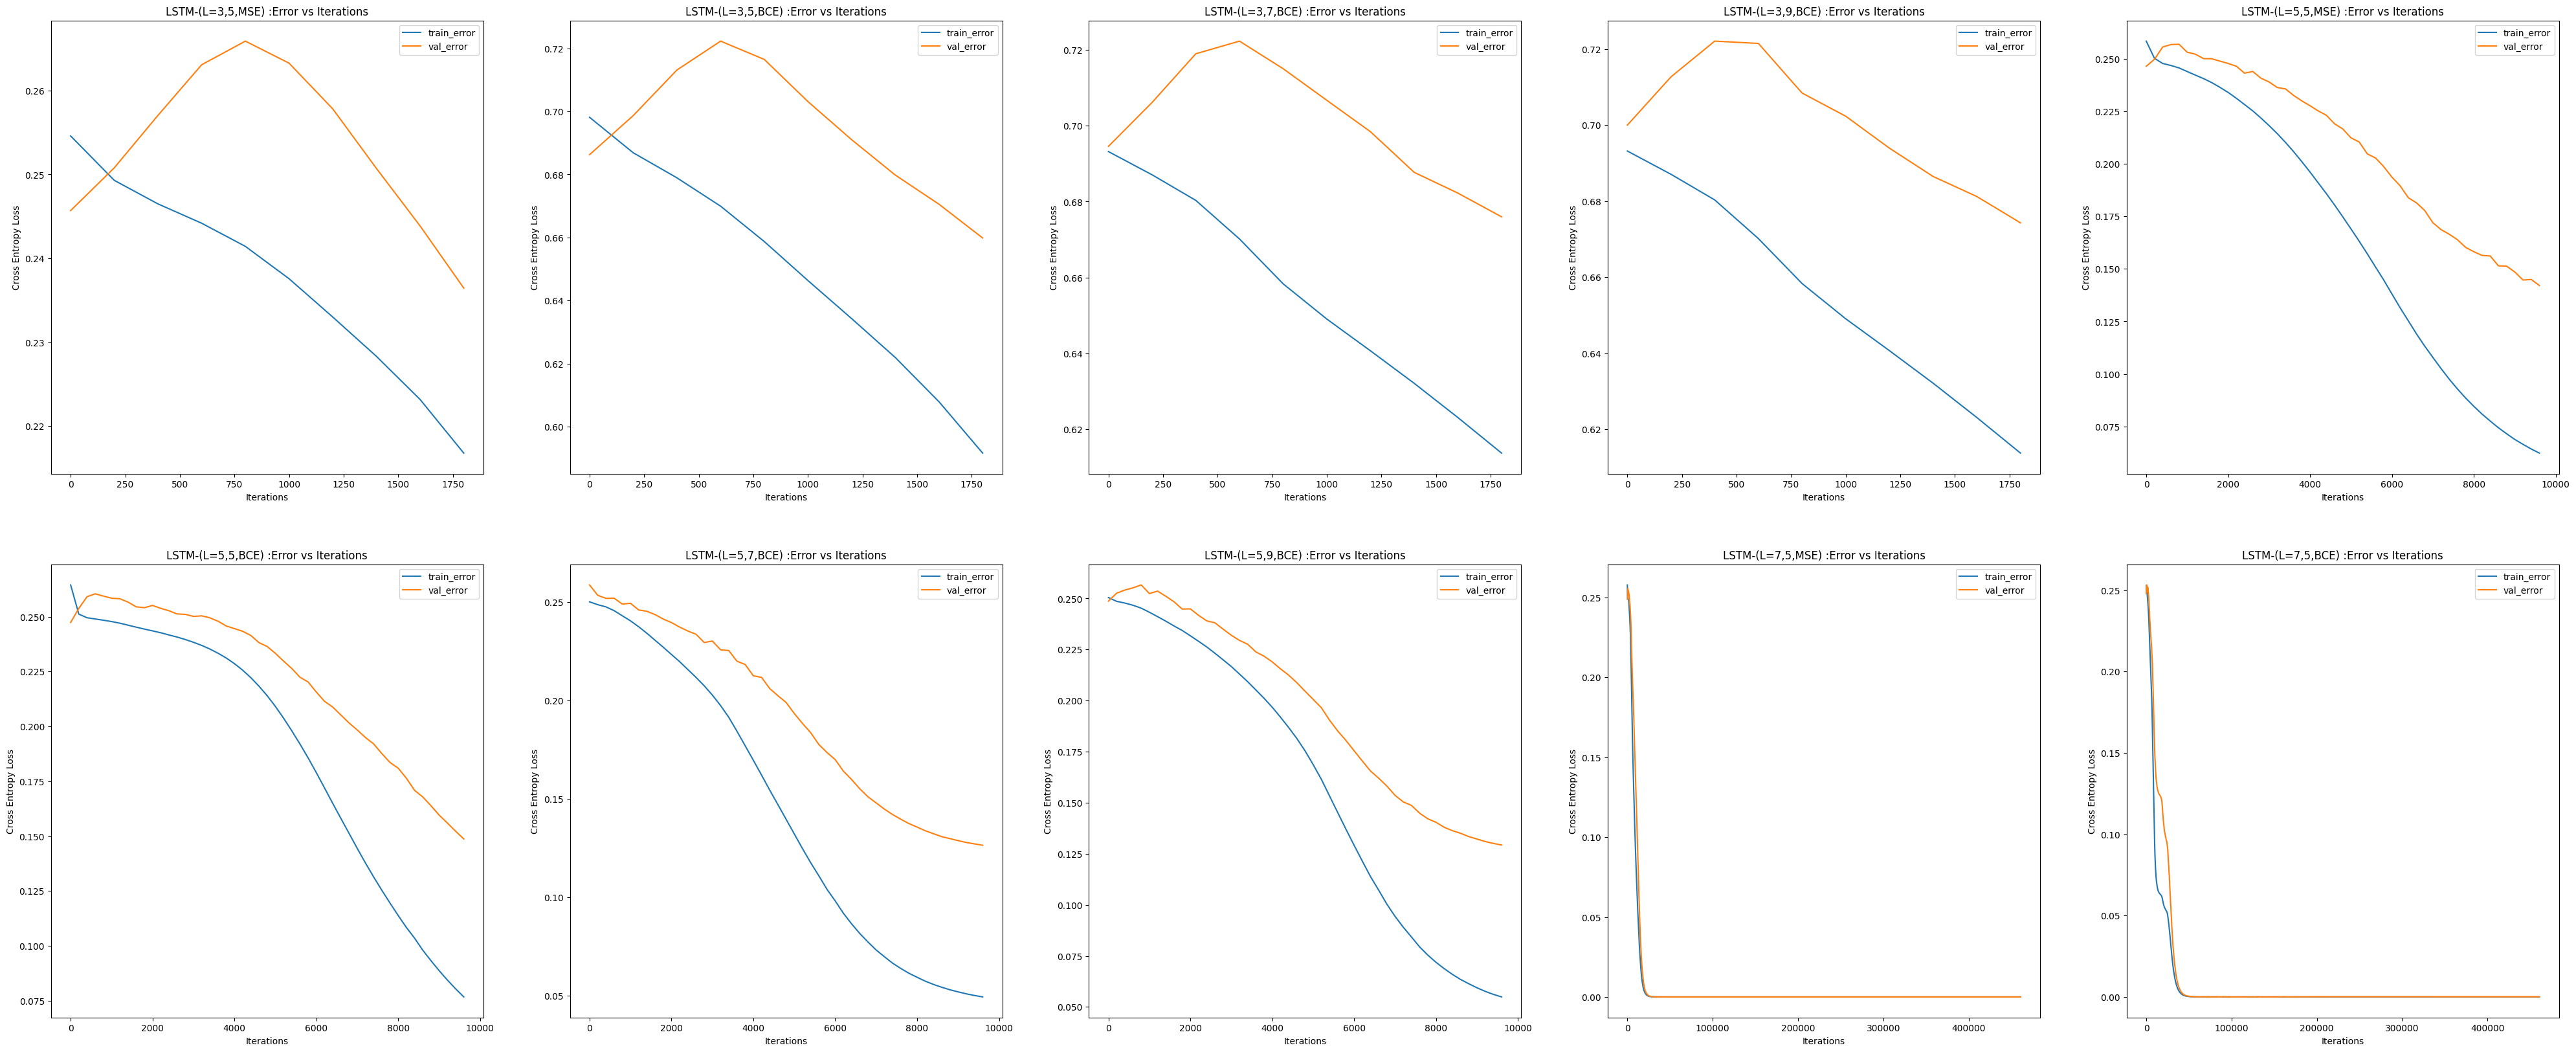

In [144]:
fig,axs=plt.subplots(2,5,figsize=(50,20))

axs[0][0].plot([200*i for i in range(len(train_error3_1))],train_error3_1,label='train_error')
axs[0][0].plot([200*i for i in range(len(train_error3_1))],val_error3_1,label='val_error')
axs[0][0].set_xlabel('Iterations')
axs[0][0].set_ylabel('Cross Entropy Loss')
axs[0][0].set_title('LSTM-(L=3,5,MSE) :Error vs Iterations')
axs[0][0].legend()

axs[0][1].plot([200*i for i in range(len(train_error3_2))],train_error3_2,label='train_error')
axs[0][1].plot([200*i for i in range(len(train_error3_2))],val_error3_2,label='val_error')
axs[0][1].set_xlabel('Iterations')
axs[0][1].set_ylabel('Cross Entropy Loss')
axs[0][1].set_title('LSTM-(L=3,5,BCE) :Error vs Iterations')
axs[0][1].legend()

axs[0][2].plot([200*i for i in range(len(train_error3_3))],train_error3_3,label='train_error')
axs[0][2].plot([200*i for i in range(len(train_error3_3))],val_error3_3,label='val_error')
axs[0][2].set_xlabel('Iterations')
axs[0][2].set_ylabel('Cross Entropy Loss')
axs[0][2].set_title('LSTM-(L=3,7,BCE) :Error vs Iterations')
axs[0][2].legend()

axs[0][3].plot([200*i for i in range(len(train_error3_4))],train_error3_3,label='train_error')
axs[0][3].plot([200*i for i in range(len(train_error3_4))],val_error3_4,label='val_error')
axs[0][3].set_xlabel('Iterations')
axs[0][3].set_ylabel('Cross Entropy Loss')
axs[0][3].set_title('LSTM-(L=3,9,BCE) :Error vs Iterations')
axs[0][3].legend()

axs[0][4].plot([200*i for i in range(len(train_error4_1))],train_error4_1,label='train_error')
axs[0][4].plot([200*i for i in range(len(train_error4_1))],val_error4_1,label='val_error')
axs[0][4].set_xlabel('Iterations')
axs[0][4].set_ylabel('Cross Entropy Loss')
axs[0][4].set_title('LSTM-(L=5,5,MSE) :Error vs Iterations')
axs[0][4].legend()


axs[1][0].plot([200*i for i in range(len(train_error4_2))],train_error4_2,label='train_error')
axs[1][0].plot([200*i for i in range(len(train_error4_1))],val_error4_2,label='val_error')
axs[1][0].set_xlabel('Iterations')
axs[1][0].set_ylabel('Cross Entropy Loss')
axs[1][0].set_title('LSTM-(L=5,5,BCE) :Error vs Iterations')
axs[1][0].legend()

axs[1][1].plot([200*i for i in range(len(train_error4_3))],train_error4_3,label='train_error')
axs[1][1].plot([200*i for i in range(len(train_error4_3))],val_error4_3,label='val_error')
axs[1][1].set_xlabel('Iterations')
axs[1][1].set_ylabel('Cross Entropy Loss')
axs[1][1].set_title('LSTM-(L=5,7,BCE) :Error vs Iterations')
axs[1][1].legend()

axs[1][2].plot([200*i for i in range(len(train_error4_4))],train_error4_4,label='train_error')
axs[1][2].plot([200*i for i in range(len(train_error4_4))],val_error4_4,label='val_error')
axs[1][2].set_xlabel('Iterations')
axs[1][2].set_ylabel('Cross Entropy Loss')
axs[1][2].set_title('LSTM-(L=5,9,BCE) :Error vs Iterations')
axs[1][2].legend()

axs[1][3].plot([200*i for i in range(len(train_error5_1))],train_error5_1,label='train_error')
axs[1][3].plot([200*i for i in range(len(train_error5_1))],val_error5_1,label='val_error')
axs[1][3].set_xlabel('Iterations')
axs[1][3].set_ylabel('Cross Entropy Loss')
axs[1][3].set_title('LSTM-(L=7,5,MSE) :Error vs Iterations')
axs[1][3].legend()

axs[1][4].plot([200*i for i in range(len(train_error5_2))],train_error5_2,label='train_error')
axs[1][4].plot([200*i for i in range(len(train_error5_2))],val_error5_2,label='val_error')
axs[1][4].set_xlabel('Iterations')
axs[1][4].set_ylabel('Cross Entropy Loss')
axs[1][4].set_title('LSTM-(L=7,5,BCE) :Error vs Iterations')
axs[1][4].legend()


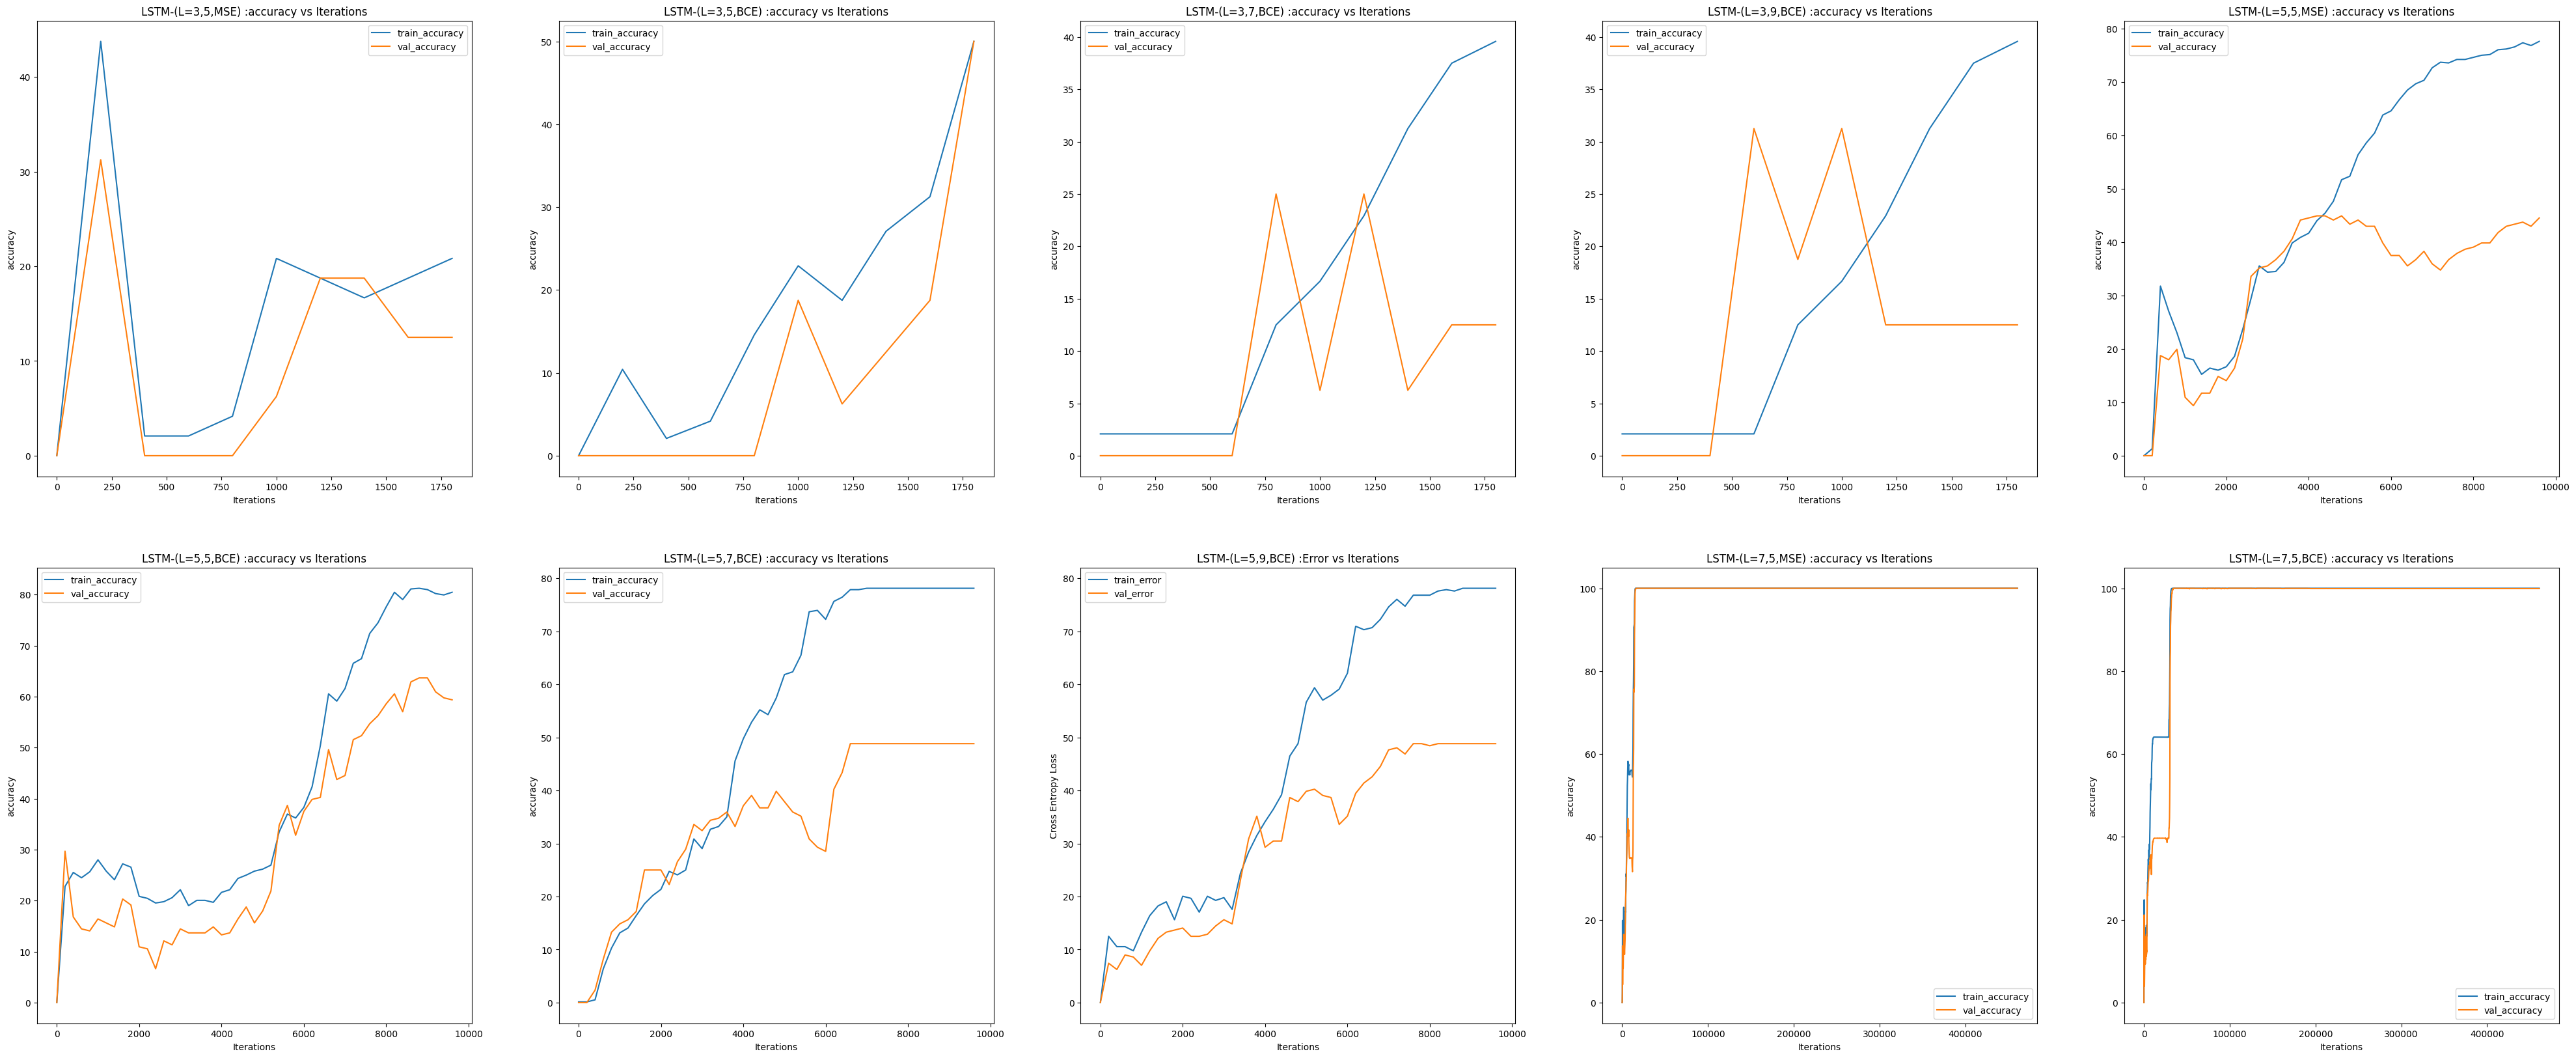

In [145]:
fig,axs=plt.subplots(2,5,figsize=(50,20))

axs[0][0].plot([200*i for i in range(len(train_accuracy3_1))],train_accuracy3_1,label='train_accuracy')
axs[0][0].plot([200*i for i in range(len(train_accuracy3_1))],val_accuracy3_1,label='val_accuracy')
axs[0][0].set_xlabel('Iterations')
axs[0][0].set_ylabel('accuracy')
axs[0][0].set_title('LSTM-(L=3,5,MSE) :accuracy vs Iterations')
axs[0][0].legend()

axs[0][1].plot([200*i for i in range(len(train_accuracy3_2))],train_accuracy3_2,label='train_accuracy')
axs[0][1].plot([200*i for i in range(len(train_accuracy3_2))],val_accuracy3_2,label='val_accuracy')
axs[0][1].set_xlabel('Iterations')
axs[0][1].set_ylabel('accuracy')
axs[0][1].set_title('LSTM-(L=3,5,BCE) :accuracy vs Iterations')
axs[0][1].legend()

axs[0][2].plot([200*i for i in range(len(train_accuracy3_3))],train_accuracy3_3,label='train_accuracy')
axs[0][2].plot([200*i for i in range(len(train_accuracy3_3))],val_accuracy3_3,label='val_accuracy')
axs[0][2].set_xlabel('Iterations')
axs[0][2].set_ylabel('accuracy')
axs[0][2].set_title('LSTM-(L=3,7,BCE) :accuracy vs Iterations')
axs[0][2].legend()

axs[0][3].plot([200*i for i in range(len(train_accuracy3_4))],train_accuracy3_3,label='train_accuracy')
axs[0][3].plot([200*i for i in range(len(train_accuracy3_4))],val_accuracy3_4,label='val_accuracy')
axs[0][3].set_xlabel('Iterations')
axs[0][3].set_ylabel('accuracy')
axs[0][3].set_title('LSTM-(L=3,9,BCE) :accuracy vs Iterations')
axs[0][3].legend()

axs[0][4].plot([200*i for i in range(len(train_accuracy4_1))],train_accuracy4_1,label='train_accuracy')
axs[0][4].plot([200*i for i in range(len(train_accuracy4_1))],val_accuracy4_1,label='val_accuracy')
axs[0][4].set_xlabel('Iterations')
axs[0][4].set_ylabel('accuracy')
axs[0][4].set_title('LSTM-(L=5,5,MSE) :accuracy vs Iterations')
axs[0][4].legend()


axs[1][0].plot([200*i for i in range(len(train_accuracy4_2))],train_accuracy4_2,label='train_accuracy')
axs[1][0].plot([200*i for i in range(len(train_accuracy4_1))],val_accuracy4_2,label='val_accuracy')
axs[1][0].set_xlabel('Iterations')
axs[1][0].set_ylabel('accuracy')
axs[1][0].set_title('LSTM-(L=5,5,BCE) :accuracy vs Iterations')
axs[1][0].legend()

axs[1][1].plot([200*i for i in range(len(train_accuracy4_3))],train_accuracy4_3,label='train_accuracy')
axs[1][1].plot([200*i for i in range(len(train_accuracy4_3))],val_accuracy4_3,label='val_accuracy')
axs[1][1].set_xlabel('Iterations')
axs[1][1].set_ylabel('accuracy')
axs[1][1].set_title('LSTM-(L=5,7,BCE) :accuracy vs Iterations')
axs[1][1].legend()

axs[1][2].plot([200*i for i in range(len(train_error4_4))],train_accuracy4_4,label='train_error')
axs[1][2].plot([200*i for i in range(len(train_error4_4))],val_accuracy4_4,label='val_error')
axs[1][2].set_xlabel('Iterations')
axs[1][2].set_ylabel('Cross Entropy Loss')
axs[1][2].set_title('LSTM-(L=5,9,BCE) :Error vs Iterations')
axs[1][2].legend()

axs[1][3].plot([200*i for i in range(len(train_error5_1))],train_accurac5_1,label='train_accuracy')
axs[1][3].plot([200*i for i in range(len(train_error5_1))],val_accuracy5_1,label='val_accuracy')
axs[1][3].set_xlabel('Iterations')
axs[1][3].set_ylabel('accuracy')
axs[1][3].set_title('LSTM-(L=7,5,MSE) :accuracy vs Iterations')
axs[1][3].legend()

axs[1][4].plot([200*i for i in range(len(train_error5_2))],train_accurac5_2,label='train_accuracy')
axs[1][4].plot([200*i for i in range(len(train_error5_2))],val_accuracy5_2,label='val_accuracy')
axs[1][4].set_xlabel('Iterations')
axs[1][4].set_ylabel('accuracy')
axs[1][4].set_title('LSTM-(L=7,5,BCE) :accuracy vs Iterations')
axs[1][4].legend()


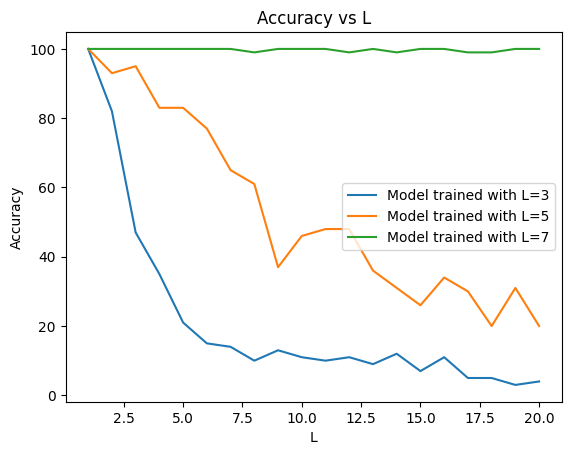

In [146]:
def accuracy_arr(model):
    accuracy=[]
    for l in range(1,21):
        [X,Y]=generate_random_data(l)
        [_,acc]=eval(model,torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.float32),criterion)
        accuracy.append(acc)
    return accuracy
acc1=accuracy_arr(model3_2)
acc2=accuracy_arr(model4_2)
acc3=accuracy_arr(model5_2)
plt.plot(range(1,21),acc1,label='Model trained with L=3')
plt.plot(range(1,21),acc2,label='Model trained with L=5')
plt.plot(range(1,21),acc3,label='Model trained with L=7')
plt.title('Accuracy vs L')
plt.xlabel('L')
plt.ylabel('Accuracy')
plt.legend()


Model Trained with 7 bits outperformed models trained with 5 and 3 btis respectively